In [ ]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

# Optional: Start a local Dask cluster for parallel processing
client = Client()  # Uses all available cores
print(client.dashboard_link)  # Monitor progress in browser

# Load your raw CSV data
# If you have multiple CSV files, use a glob pattern like "data_*.csv"
ddf = dd.read_csv("smart_home_dataset_with_weather.csv", dtype={
    'Unix Timestamp': 'int64',
    'Weather_Type': 'object',
    'Outside_Temperature_C': 'float64',
    'Television': 'int64',
    'Dryer': 'int64',
    'Oven': 'int64',
    'Refrigerator': 'int64',
    'Microwave': 'int64',
    'Line Voltage': 'float64',
    'Voltage': 'float64',
    'Apparent Power': 'float64',
    'Energy Consumption (kWh)': 'float64'
})

# Convert Unix timestamp to datetime
ddf['timestamp'] = dd.to_datetime(ddf['Unix Timestamp'], unit='s')

# Create partitioning columns
ddf['year'] = ddf['timestamp'].dt.year
ddf['month'] = ddf['timestamp'].dt.month

# Set timestamp as index for efficient time-series operations
ddf = ddf.set_index('timestamp')

# Write to monthly-partitioned Parquet
output_path = "energy_data_partitioned"

print("Writing partitioned Parquet files...")
ddf.to_parquet(
    output_path,
    engine='pyarrow',
    partition_on=['year', 'month'],
    compression='snappy',
    write_index=True,
    overwrite=True  # Use if re-running
)

print(f"✓ Parquet files written to {output_path}/")
print(f"  Structure: {output_path}/year=YYYY/month=MM/*.parquet")

# Optional: Print partition info
import os
partitions = [d for d in os.listdir(output_path) if d.startswith('year=')]
print(f"✓ Created {len(partitions)} year partitions")

client.close()  # Clean up Dask client


/usr/local/lib/python3.12/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45663 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:34859
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:45663/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39601'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44685'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36137 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36137
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:41966
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:38697 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38697
IN

http://127.0.0.1:45663/status
Writing partitioned Parquet files...


INFO:distributed.scheduler:Remove client Client-93730e5c-d2f7-11f0-8095-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:41990; closing.
INFO:distributed.scheduler:Remove client Client-93730e5c-d2f7-11f0-8095-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-93730e5c-d2f7-11f0-8095-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1765062131.5232427') (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39601'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:44685'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:41978; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:41966; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.

✓ Parquet files written to energy_data_partitioned/
  Structure: energy_data_partitioned/year=YYYY/month=MM/*.parquet
✓ Created 5 year partitions


INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:44685' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:39601' closed.
INFO:distributed.scheduler:Closing scheduler. Reason: unknown
INFO:distributed.scheduler:Scheduler closing all comms


In [ ]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the partitioned Parquet dataset
print("Loading partitioned Parquet data...")
ddf = dd.read_parquet("energy_data_partitioned", engine='pyarrow')

print(f"✓ Loaded {ddf.npartitions} partitions")
print(f"✓ Date range: {ddf.index.min().compute()} to {ddf.index.max().compute()}")
print(f"✓ Total rows: {len(ddf):,}")

# For most Matplotlib operations, we'll work with the full dataset in pandas
# For 4 years of hourly data (~35k-105k rows), this should fit in memory
print("\nConverting to pandas for analysis...")
df = ddf.compute()
df = df.sort_index()

print(f"✓ DataFrame shape: {df.shape}")
print(f"✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Add time-based features for analysis
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['date'] = df.index.date

device_cols = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']

Loading partitioned Parquet data...
✓ Loaded 49 partitions
✓ Date range: 2019-12-25 03:15:47 to 2023-12-03 17:55:59
✓ Total rows: 500,000

Converting to pandas for analysis...
✓ DataFrame shape: (500000, 14)
✓ Memory usage: 54.05 MB


In [ ]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


[1/10] Generating time series overview...


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause tim

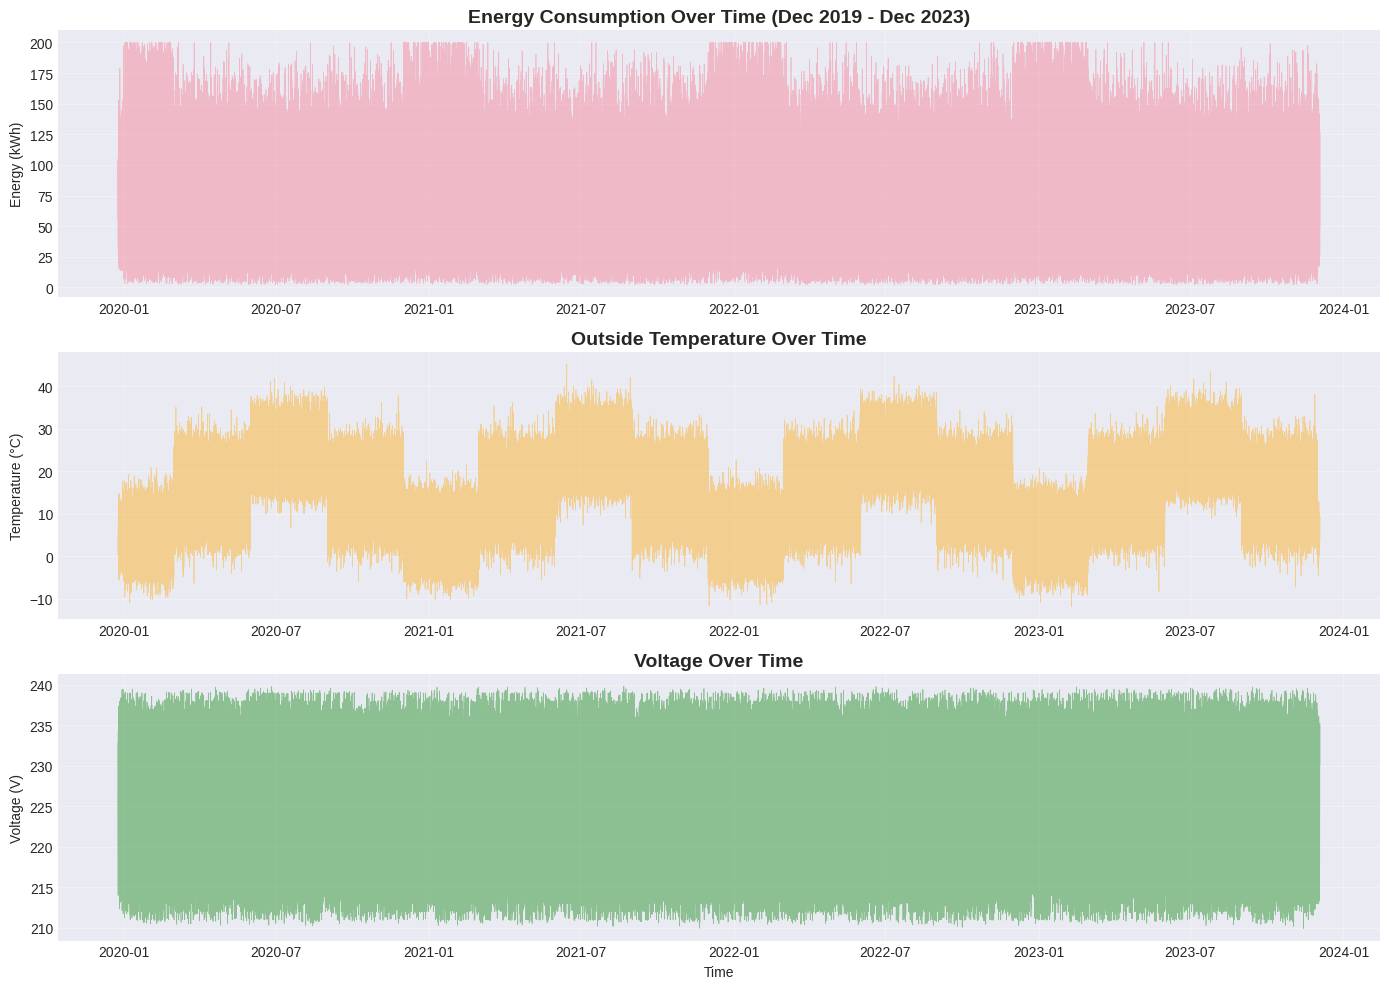

In [ ]:
#==============================================================================
# 1. TIME SERIES OVERVIEW
#==============================================================================
print("\n[1/10] Generating time series overview...")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Energy consumption over time
axes[0].plot(df.index, df['Energy Consumption (kWh)'], alpha=0.4, linewidth=0.5)
axes[0].set_title('Energy Consumption Over Time (Dec 2019 - Dec 2023)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Energy (kWh)')
axes[0].grid(True, alpha=0.3)

# Temperature over time
axes[1].plot(df.index, df['Outside_Temperature_C'], alpha=0.4, linewidth=0.5, color='orange')
axes[1].set_title('Outside Temperature Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True, alpha=0.3)

# Voltage over time
axes[2].plot(df.index, df['Voltage'], alpha=0.4, linewidth=0.5, color='green')
axes[2].set_title('Voltage Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Voltage (V)')
axes[2].set_xlabel('Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_timeseries_overview.png', dpi=150, bbox_inches='tight')
plt.show()

[2/10] Generating daily patterns...


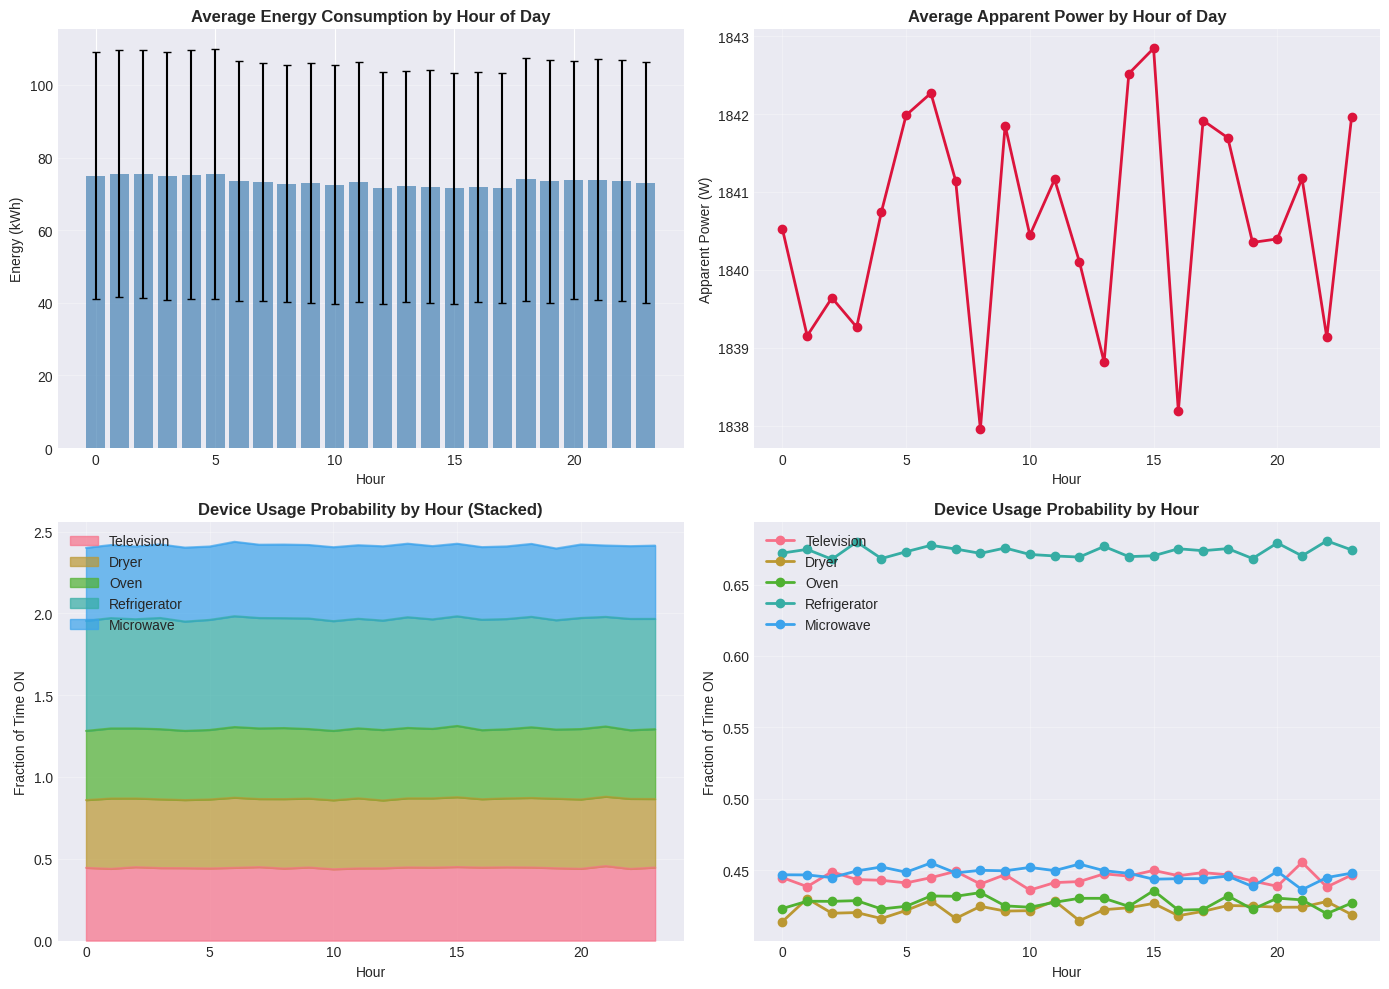

In [ ]:
#==============================================================================
# 2. DAILY PATTERNS (Hour of Day)
#==============================================================================
print("[2/10] Generating daily patterns...")

hourly_stats = df.groupby('hour').agg({
    'Energy Consumption (kWh)': ['mean', 'std'],
    'Apparent Power': 'mean',
    'Television': 'mean',
    'Dryer': 'mean',
    'Oven': 'mean',
    'Refrigerator': 'mean',
    'Microwave': 'mean'
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Energy by hour
ax = axes[0, 0]
ax.bar(hourly_stats.index, hourly_stats[('Energy Consumption (kWh)', 'mean')],
       yerr=hourly_stats[('Energy Consumption (kWh)', 'std')],
       capsize=3, alpha=0.7, color='steelblue')
ax.set_title('Average Energy Consumption by Hour of Day', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour')
ax.set_ylabel('Energy (kWh)')
ax.grid(True, alpha=0.3, axis='y')

# Apparent power by hour
ax = axes[0, 1]
ax.plot(hourly_stats.index, hourly_stats[('Apparent Power', 'mean')],
        marker='o', linewidth=2, markersize=6, color='crimson')
ax.set_title('Average Apparent Power by Hour of Day', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour')
ax.set_ylabel('Apparent Power (W)')
ax.grid(True, alpha=0.3)

# Device usage by hour (stacked)
ax = axes[1, 0]
device_hourly = hourly_stats[[col for col in hourly_stats.columns if col[0] in device_cols]]
device_hourly.columns = device_cols
device_hourly.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
ax.set_title('Device Usage Probability by Hour (Stacked)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour')
ax.set_ylabel('Fraction of Time ON')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

# Device usage by hour (separate lines)
ax = axes[1, 1]
device_hourly.plot(ax=ax, marker='o', linewidth=2)
ax.set_title('Device Usage Probability by Hour', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour')
ax.set_ylabel('Fraction of Time ON')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_daily_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

[3/10] Generating weekly patterns...


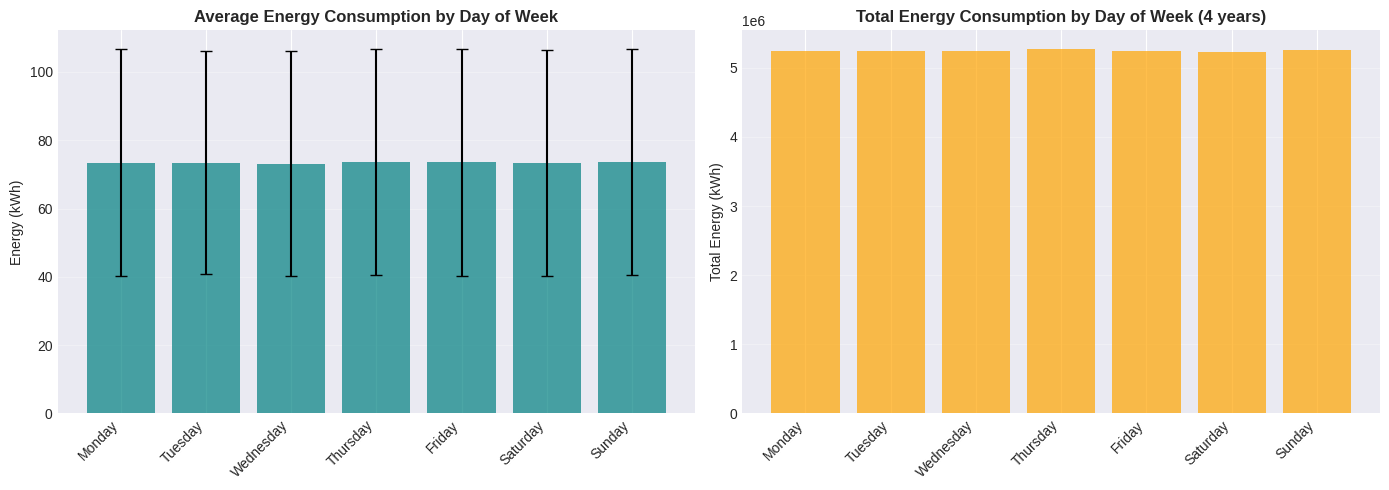

In [ ]:
#==============================================================================
# 3. WEEKLY PATTERNS (Day of Week)
#==============================================================================
print("[3/10] Generating weekly patterns...")

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_stats = df.groupby('dayofweek').agg({
    'Energy Consumption (kWh)': ['mean', 'sum', 'std']
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average energy by day of week
ax = axes[0]
ax.bar(range(7), weekly_stats[('Energy Consumption (kWh)', 'mean')],
       yerr=weekly_stats[('Energy Consumption (kWh)', 'std')],
       capsize=4, alpha=0.7, color='teal')
ax.set_xticks(range(7))
ax.set_xticklabels(day_names, rotation=45, ha='right')
ax.set_title('Average Energy Consumption by Day of Week', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (kWh)')
ax.grid(True, alpha=0.3, axis='y')

# Total energy by day of week
ax = axes[1]
ax.bar(range(7), weekly_stats[('Energy Consumption (kWh)', 'sum')],
       alpha=0.7, color='orange')
ax.set_xticks(range(7))
ax.set_xticklabels(day_names, rotation=45, ha='right')
ax.set_title('Total Energy Consumption by Day of Week (4 years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Energy (kWh)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('03_weekly_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

[4/10] Generating seasonal patterns...


/tmp/ipython-input-813101525.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df.resample('M').agg({


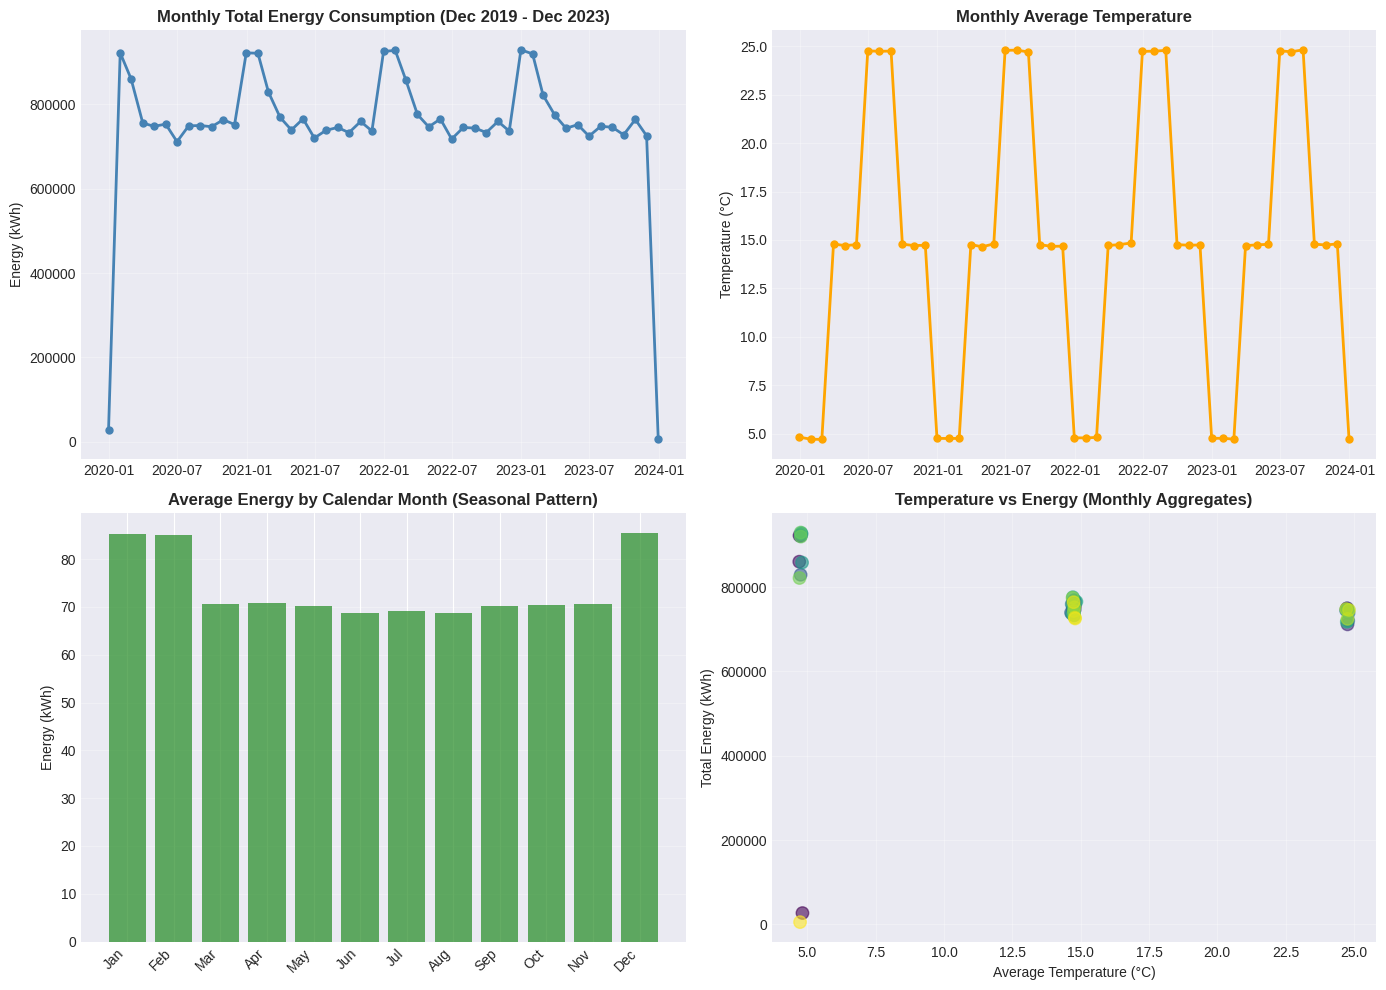

In [ ]:
#==============================================================================
# 4. MONTHLY AND SEASONAL PATTERNS
#==============================================================================
print("[4/10] Generating seasonal patterns...")

# Monthly aggregation
monthly_stats = df.resample('M').agg({
    'Energy Consumption (kWh)': 'sum',
    'Outside_Temperature_C': 'mean',
    'Apparent Power': 'mean'
})

# By calendar month (across all years)
month_stats = df.groupby('month').agg({
    'Energy Consumption (kWh)': ['mean', 'sum'],
    'Outside_Temperature_C': 'mean'
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total energy by month (time series)
ax = axes[0, 0]
ax.plot(monthly_stats.index, monthly_stats['Energy Consumption (kWh)'],
        marker='o', linewidth=2, markersize=5, color='steelblue')
ax.set_title('Monthly Total Energy Consumption (Dec 2019 - Dec 2023)',
             fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (kWh)')
ax.grid(True, alpha=0.3)

# Average temperature by month (time series)
ax = axes[0, 1]
ax.plot(monthly_stats.index, monthly_stats['Outside_Temperature_C'],
        marker='o', linewidth=2, markersize=5, color='orange')
ax.set_title('Monthly Average Temperature', fontsize=12, fontweight='bold')
ax.set_ylabel('Temperature (°C)')
ax.grid(True, alpha=0.3)

# Seasonal pattern (average by calendar month)
ax = axes[1, 0]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.bar(range(1, 13), month_stats[('Energy Consumption (kWh)', 'mean')],
       alpha=0.7, color='forestgreen')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names, rotation=45, ha='right')
ax.set_title('Average Energy by Calendar Month (Seasonal Pattern)',
             fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (kWh)')
ax.grid(True, alpha=0.3, axis='y')

# Temperature vs Energy (monthly)
ax = axes[1, 1]
ax.scatter(monthly_stats['Outside_Temperature_C'],
           monthly_stats['Energy Consumption (kWh)'],
           s=80, alpha=0.6, c=range(len(monthly_stats)), cmap='viridis')
ax.set_title('Temperature vs Energy (Monthly Aggregates)', fontsize=12, fontweight='bold')
ax.set_xlabel('Average Temperature (°C)')
ax.set_ylabel('Total Energy (kWh)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_seasonal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

[5/10] Generating weather analysis...


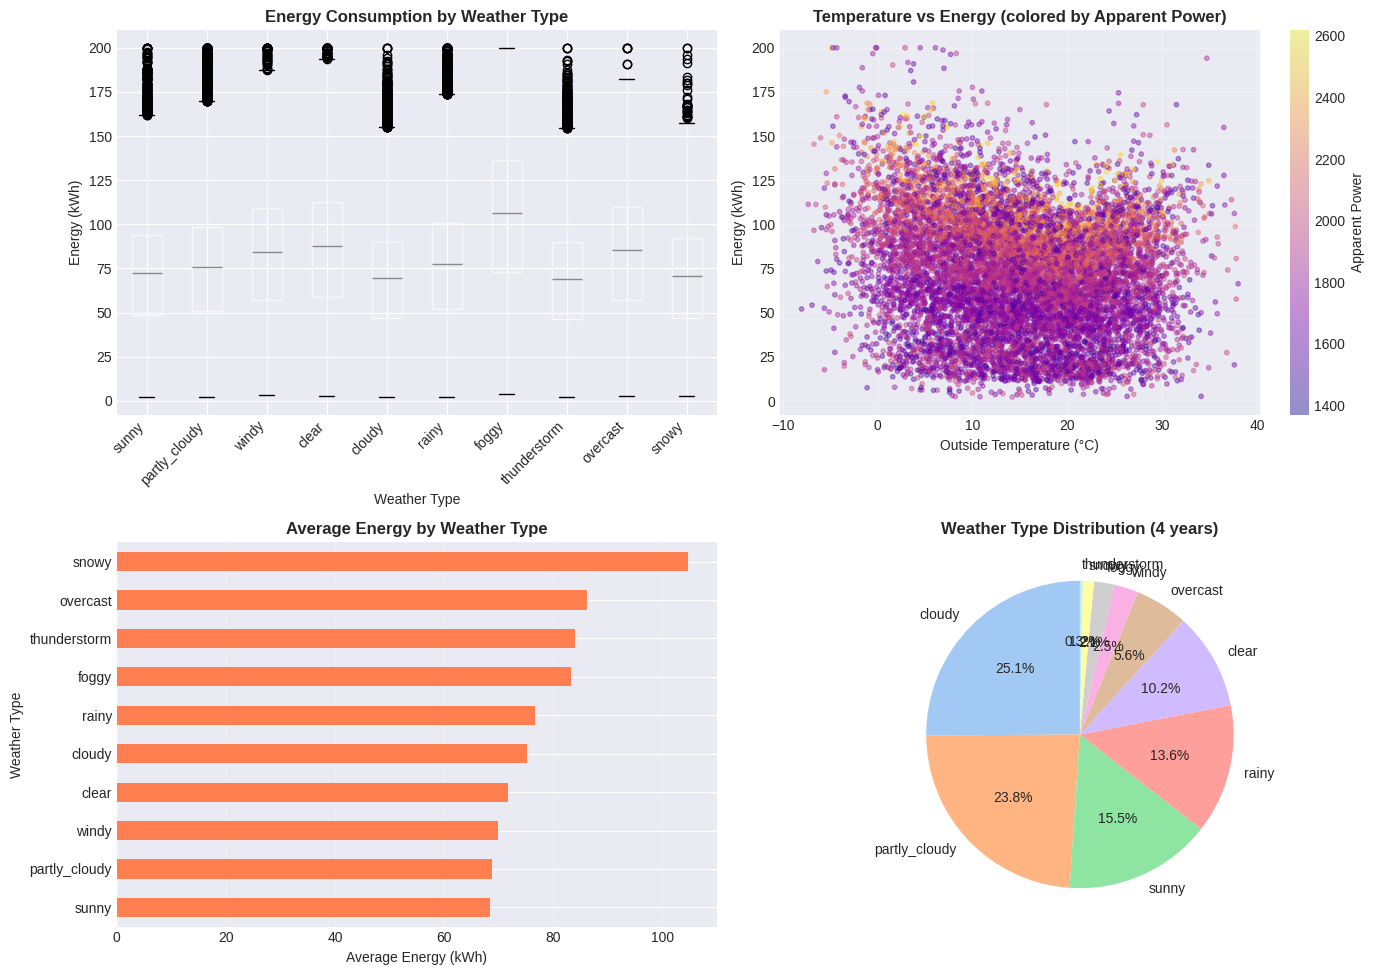

In [ ]:
#==============================================================================
# 5. WEATHER IMPACT
#==============================================================================
print("[5/10] Generating weather analysis...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Energy by weather type (box plot)
ax = axes[0, 0]
weather_order = df.groupby('Weather_Type')['Energy Consumption (kWh)'].median().sort_values().index
df.boxplot(column='Energy Consumption (kWh)', by='Weather_Type', ax=ax,
           positions=range(len(weather_order)))
ax.set_xticklabels(weather_order, rotation=45, ha='right')
ax.set_title('Energy Consumption by Weather Type', fontsize=12, fontweight='bold')
ax.set_xlabel('Weather Type')
ax.set_ylabel('Energy (kWh)')
plt.suptitle('')

# Temperature vs Energy (scatter with density)
ax = axes[0, 1]
# Sample for performance if dataset is huge
sample_df = df.sample(min(10000, len(df)), random_state=42)
scatter = ax.scatter(sample_df['Outside_Temperature_C'],
                     sample_df['Energy Consumption (kWh)'],
                     c=sample_df['Apparent Power'], s=10, alpha=0.4, cmap='plasma')
ax.set_title('Temperature vs Energy (colored by Apparent Power)', fontsize=12, fontweight='bold')
ax.set_xlabel('Outside Temperature (°C)')
ax.set_ylabel('Energy (kWh)')
plt.colorbar(scatter, ax=ax, label='Apparent Power')
ax.grid(True, alpha=0.3)

# Average energy and count by weather type
ax = axes[1, 0]
weather_stats = df.groupby('Weather_Type').agg({
    'Energy Consumption (kWh)': 'mean'
}).sort_values('Energy Consumption (kWh)')
weather_stats.plot(kind='barh', ax=ax, legend=False, color='coral')
ax.set_title('Average Energy by Weather Type', fontsize=12, fontweight='bold')
ax.set_xlabel('Average Energy (kWh)')
ax.set_ylabel('Weather Type')
ax.grid(True, alpha=0.3, axis='x')

# Weather type frequency
ax = axes[1, 1]
weather_counts = df['Weather_Type'].value_counts()
ax.pie(weather_counts.values, labels=weather_counts.index, autopct='%1.1f%%',
       startangle=90, colors=sns.color_palette('pastel'))
ax.set_title('Weather Type Distribution (4 years)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('05_weather_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

[6/10] Generating device analysis...


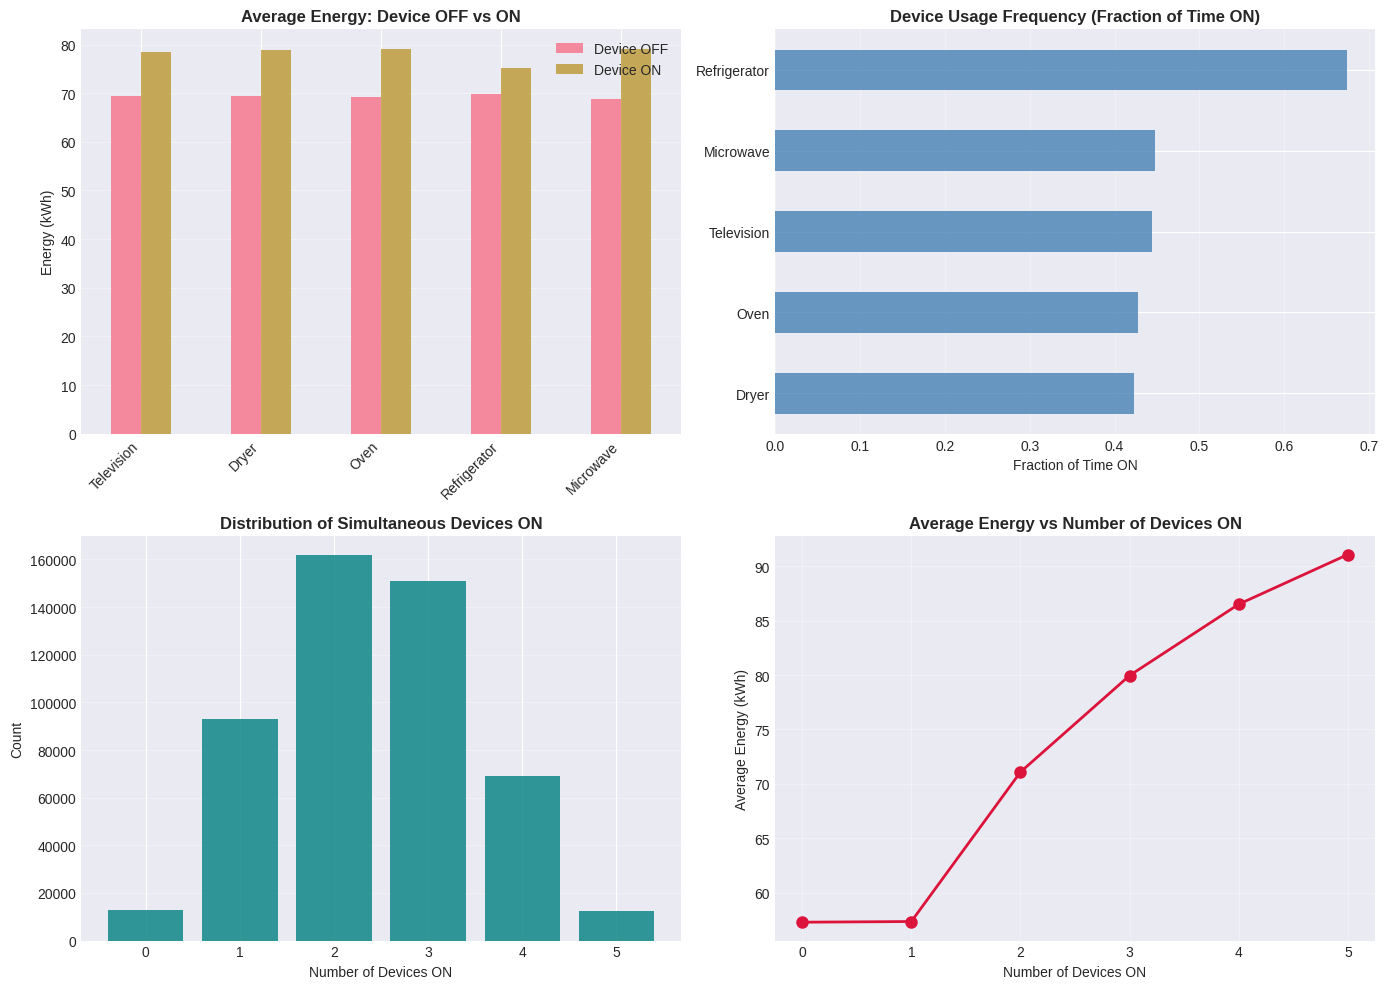

In [ ]:
#==============================================================================
# 6. DEVICE ANALYSIS
#==============================================================================
print("[6/10] Generating device analysis...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Energy when device ON vs OFF
ax = axes[0, 0]
device_impact = pd.DataFrame({
    device: df.groupby(device)['Energy Consumption (kWh)'].mean()
    for device in device_cols
}).T
device_impact.columns = ['OFF', 'ON']
device_impact['Lift'] = device_impact['ON'] - device_impact['OFF']
device_impact[['OFF', 'ON']].plot(kind='bar', ax=ax, alpha=0.8)
ax.set_title('Average Energy: Device OFF vs ON', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (kWh)')
ax.set_xticklabels(device_cols, rotation=45, ha='right')
ax.legend(['Device OFF', 'Device ON'])
ax.grid(True, alpha=0.3, axis='y')

# Device usage frequency
ax = axes[0, 1]
device_usage = df[device_cols].mean().sort_values()
device_usage.plot(kind='barh', ax=ax, color='steelblue', alpha=0.8)
ax.set_title('Device Usage Frequency (Fraction of Time ON)', fontsize=12, fontweight='bold')
ax.set_xlabel('Fraction of Time ON')
ax.grid(True, alpha=0.3, axis='x')

# Number of simultaneous devices ON
ax = axes[1, 0]
df['num_devices_on'] = df[device_cols].sum(axis=1)
devices_on_dist = df['num_devices_on'].value_counts().sort_index()
ax.bar(devices_on_dist.index, devices_on_dist.values, alpha=0.8, color='teal')
ax.set_title('Distribution of Simultaneous Devices ON', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Devices ON')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.3, axis='y')

# Energy vs number of devices ON
ax = axes[1, 1]
energy_by_devices = df.groupby('num_devices_on')['Energy Consumption (kWh)'].mean()
ax.plot(energy_by_devices.index, energy_by_devices.values,
        marker='o', linewidth=2, markersize=8, color='crimson')
ax.set_title('Average Energy vs Number of Devices ON', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Devices ON')
ax.set_ylabel('Average Energy (kWh)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_device_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

[7/10] Generating voltage and power analysis...


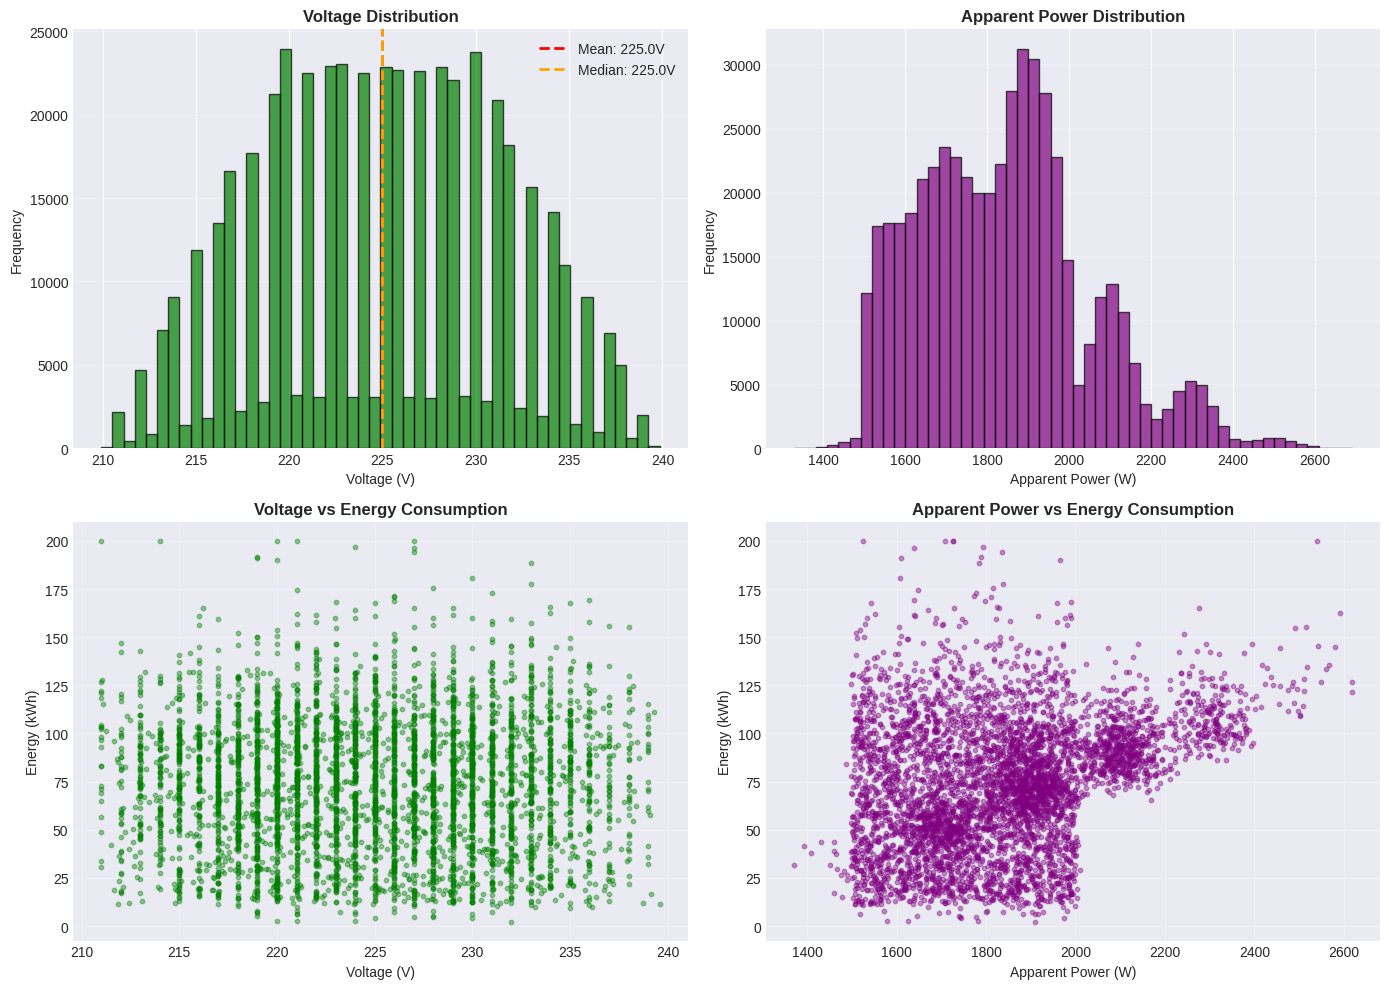

In [ ]:
#==============================================================================
# 7. VOLTAGE AND POWER ANALYSIS
#==============================================================================
print("[7/10] Generating voltage and power analysis...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Voltage distribution
ax = axes[0, 0]
ax.hist(df['Voltage'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax.axvline(df['Voltage'].mean(), color='red', linestyle='--', linewidth=2,
           label=f"Mean: {df['Voltage'].mean():.1f}V")
ax.axvline(df['Voltage'].median(), color='orange', linestyle='--', linewidth=2,
           label=f"Median: {df['Voltage'].median():.1f}V")
ax.set_title('Voltage Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Apparent Power distribution
ax = axes[0, 1]
ax.hist(df['Apparent Power'], bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.set_title('Apparent Power Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Apparent Power (W)')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3, axis='y')

# Voltage vs Energy
ax = axes[1, 0]
sample_df = df.sample(min(5000, len(df)), random_state=42)
ax.scatter(sample_df['Voltage'], sample_df['Energy Consumption (kWh)'],
           s=10, alpha=0.4, color='green')
ax.set_title('Voltage vs Energy Consumption', fontsize=12, fontweight='bold')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Energy (kWh)')
ax.grid(True, alpha=0.3)

# Apparent Power vs Energy
ax = axes[1, 1]
ax.scatter(sample_df['Apparent Power'], sample_df['Energy Consumption (kWh)'],
           s=10, alpha=0.4, color='purple')
ax.set_title('Apparent Power vs Energy Consumption', fontsize=12, fontweight='bold')
ax.set_xlabel('Apparent Power (W)')
ax.set_ylabel('Energy (kWh)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('07_voltage_power_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

[8/10] Generating correlation heatmap...


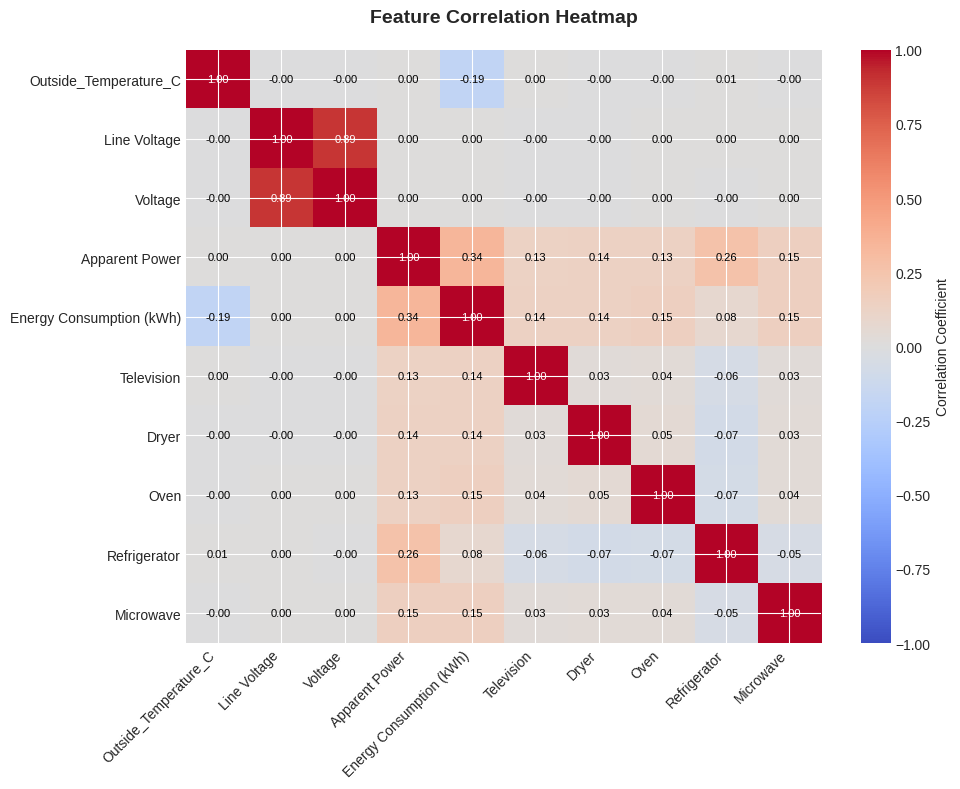

In [ ]:
#==============================================================================
# 8. CORRELATION HEATMAP
#==============================================================================
print("[8/10] Generating correlation heatmap...")

numerical_cols = ['Outside_Temperature_C', 'Line Voltage', 'Voltage',
                  'Apparent Power', 'Energy Consumption (kWh)'] + device_cols

corr_matrix = df[numerical_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(len(numerical_cols)))
ax.set_yticks(range(len(numerical_cols)))
ax.set_xticklabels(numerical_cols, rotation=45, ha='right')
ax.set_yticklabels(numerical_cols)

# Add correlation values
for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha='center', va='center',
                      color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                      fontsize=8)

plt.colorbar(im, ax=ax, label='Correlation Coefficient')
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('08_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

[9/10] Generating rolling averages...


INFO:distributed.core:Event loop was unresponsive in Nanny for 6.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 6.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


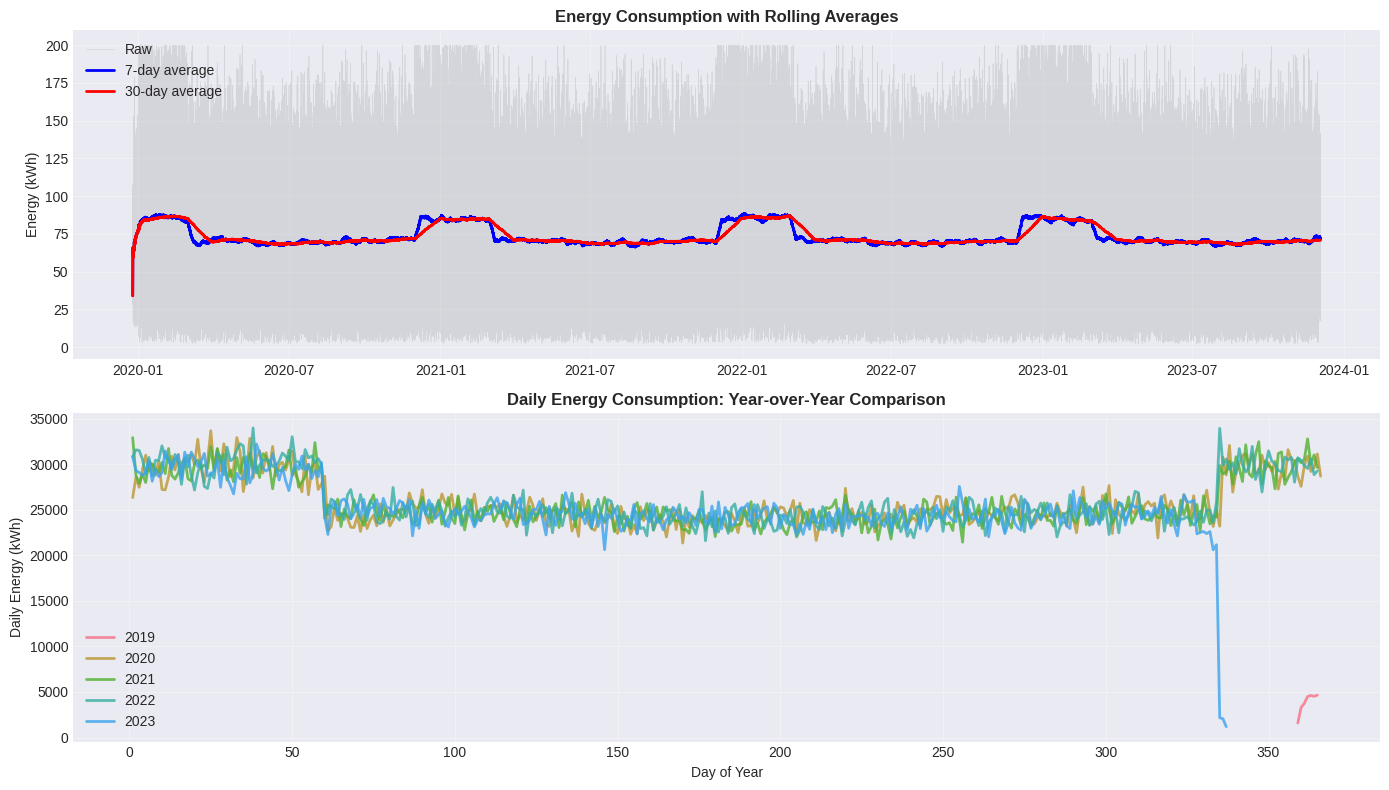

In [ ]:
#==============================================================================
# 9. ROLLING AVERAGES AND TRENDS
#==============================================================================
print("[9/10] Generating rolling averages...")

# Calculate rolling averages
df_sorted = df.sort_index()
df_sorted['energy_7d_avg'] = df_sorted['Energy Consumption (kWh)'].rolling('7D').mean()
df_sorted['energy_30d_avg'] = df_sorted['Energy Consumption (kWh)'].rolling('30D').mean()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Energy with rolling averages
ax = axes[0]
ax.plot(df_sorted.index, df_sorted['Energy Consumption (kWh)'],
        alpha=0.2, linewidth=0.5, label='Raw', color='gray')
ax.plot(df_sorted.index, df_sorted['energy_7d_avg'],
        linewidth=2, label='7-day average', color='blue')
ax.plot(df_sorted.index, df_sorted['energy_30d_avg'],
        linewidth=2, label='30-day average', color='red')
ax.set_title('Energy Consumption with Rolling Averages', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (kWh)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Year-over-year comparison
ax = axes[1]
df_sorted['year_label'] = df_sorted['year']
for year in sorted(df_sorted['year_label'].unique()):
    year_data = df_sorted[df_sorted['year_label'] == year].resample('D')['Energy Consumption (kWh)'].sum()
    year_data.index = year_data.index.dayofyear
    ax.plot(year_data.index, year_data.values, label=str(year), linewidth=2, alpha=0.8)

ax.set_title('Daily Energy Consumption: Year-over-Year Comparison', fontsize=12, fontweight='bold')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Daily Energy (kWh)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('09_rolling_trends.png', dpi=150, bbox_inches='tight')
plt.show()

[10/10] Generating summary statistics...


/tmp/ipython-input-3629059426.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yearly_totals = df.groupby('year')['Energy Consumption (kWh)'].sum()
/tmp/ipython-input-3629059426.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  records_per_year = df.groupby('year').size()


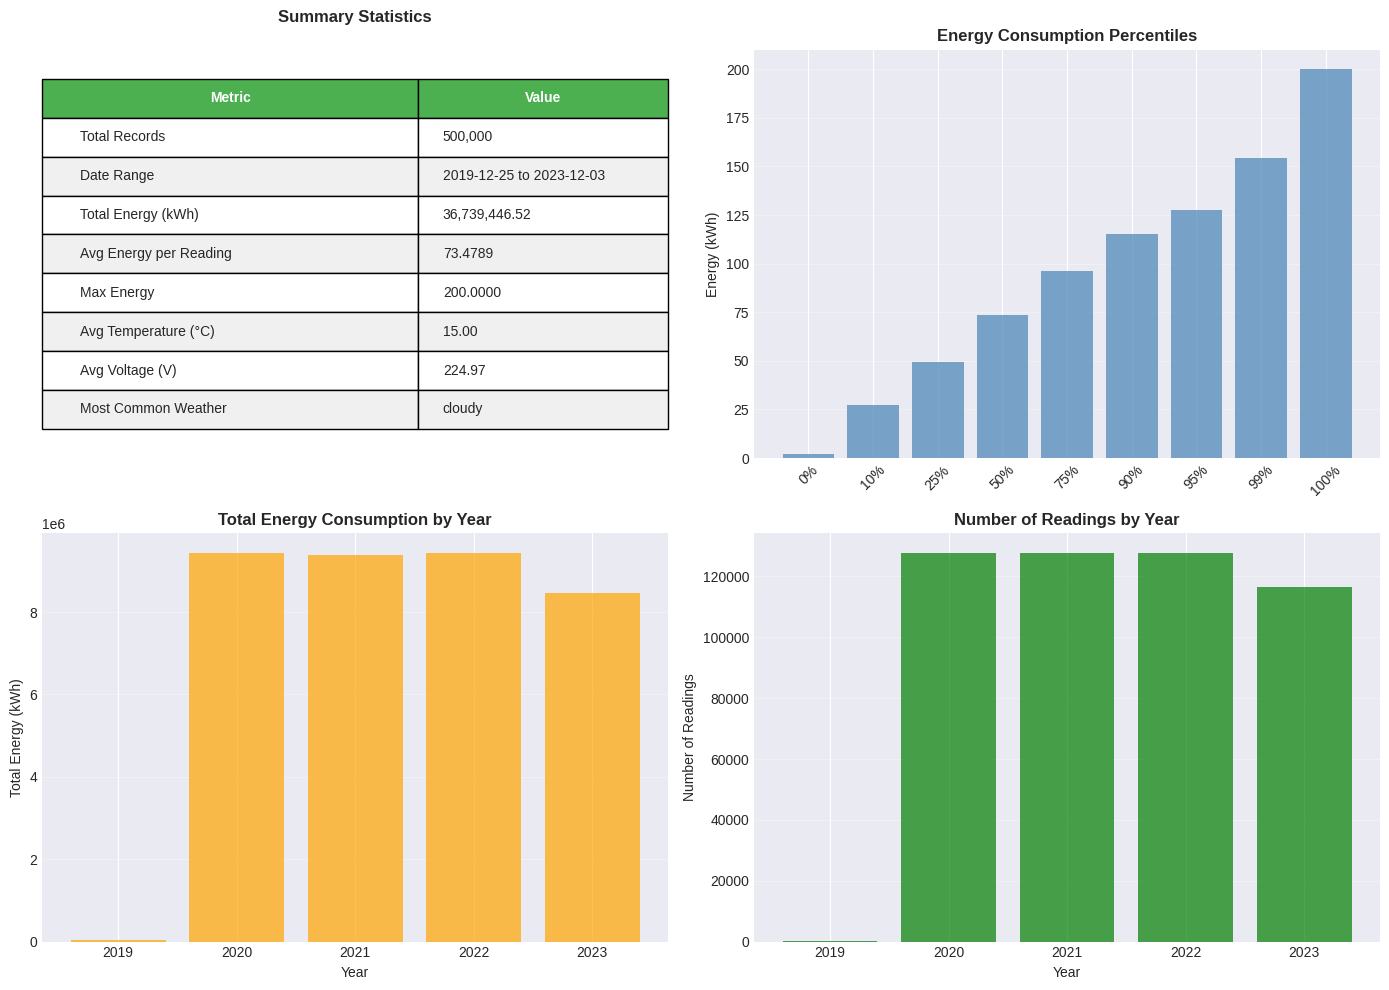


✓ All visualizations completed!

Generated 10 comprehensive visualization files:
  01_timeseries_overview.png
  02_daily_patterns.png
  03_weekly_patterns.png
  04_seasonal_patterns.png
  05_weather_analysis.png
  06_device_analysis.png
  07_voltage_power_analysis.png
  08_correlation_heatmap.png
  09_rolling_trends.png
  10_summary_statistics.png


In [ ]:
#==============================================================================
# 10. SUMMARY STATISTICS
#==============================================================================
print("[10/10] Generating summary statistics...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall statistics table
ax = axes[0, 0]
ax.axis('tight')
ax.axis('off')

summary_data = {
    'Metric': [
        'Total Records',
        'Date Range',
        'Total Energy (kWh)',
        'Avg Energy per Reading',
        'Max Energy',
        'Avg Temperature (°C)',
        'Avg Voltage (V)',
        'Most Common Weather'
    ],
    'Value': [
        f"{len(df):,}",
        f"{df.index.min().date()} to {df.index.max().date()}",
        f"{df['Energy Consumption (kWh)'].sum():,.2f}",
        f"{df['Energy Consumption (kWh)'].mean():.4f}",
        f"{df['Energy Consumption (kWh)'].max():.4f}",
        f"{df['Outside_Temperature_C'].mean():.2f}",
        f"{df['Voltage'].mean():.2f}",
        f"{df['Weather_Type'].mode()[0]}"
    ]
}

table = ax.table(cellText=[[summary_data['Metric'][i], summary_data['Value'][i]]
                           for i in range(len(summary_data['Metric']))],
                colLabels=['Metric', 'Value'],
                cellLoc='left',
                loc='center',
                colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(summary_data['Metric']) + 1):
    if i == 0:
        table[(i, 0)].set_facecolor('#4CAF50')
        table[(i, 1)].set_facecolor('#4CAF50')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    else:
        table[(i, 0)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        table[(i, 1)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)

# Energy distribution by percentile
ax = axes[0, 1]
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
energy_percentiles = [df['Energy Consumption (kWh)'].quantile(p/100) for p in percentiles]
ax.bar(range(len(percentiles)), energy_percentiles, alpha=0.7, color='steelblue')
ax.set_xticks(range(len(percentiles)))
ax.set_xticklabels([f'{p}%' for p in percentiles], rotation=45)
ax.set_title('Energy Consumption Percentiles', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (kWh)')
ax.grid(True, alpha=0.3, axis='y')

# Yearly totals
ax = axes[1, 0]
yearly_totals = df.groupby('year')['Energy Consumption (kWh)'].sum()
ax.bar(yearly_totals.index, yearly_totals.values, alpha=0.7, color='orange')
ax.set_title('Total Energy Consumption by Year', fontsize=12, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Total Energy (kWh)')
ax.grid(True, alpha=0.3, axis='y')

# Records per year
ax = axes[1, 1]
records_per_year = df.groupby('year').size()
ax.bar(records_per_year.index, records_per_year.values, alpha=0.7, color='green')
ax.set_title('Number of Readings by Year', fontsize=12, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Readings')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('10_summary_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("✓ All visualizations completed!")
print("="*70)
print(f"\nGenerated 10 comprehensive visualization files:")
print("  01_timeseries_overview.png")
print("  02_daily_patterns.png")
print("  03_weekly_patterns.png")
print("  04_seasonal_patterns.png")
print("  05_weather_analysis.png")
print("  06_device_analysis.png")
print("  07_voltage_power_analysis.png")
print("  08_correlation_heatmap.png")
print("  09_rolling_trends.png")
print("  10_summary_statistics.png")


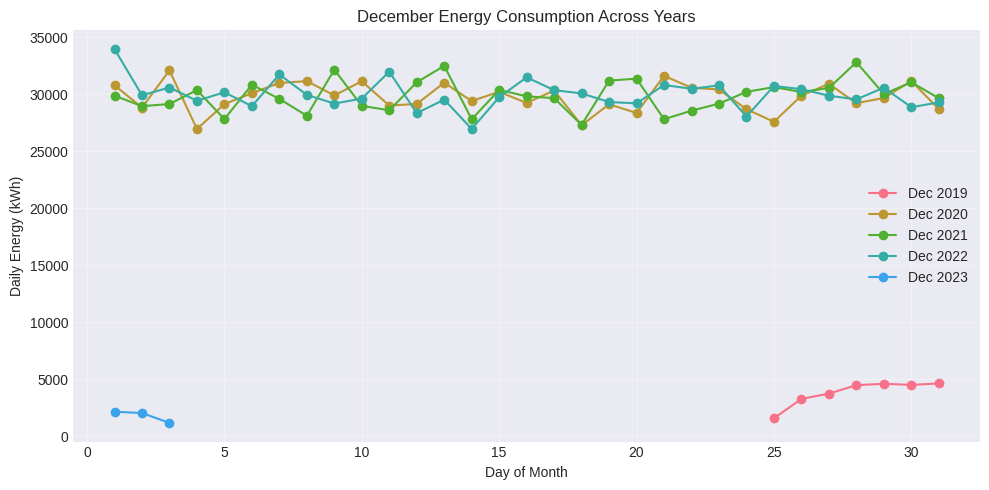

In [ ]:
import dask.dataframe as dd

# Load only specific partitions
ddf = dd.read_parquet("energy_data_partitioned", engine='pyarrow')

# Example 1: Only summer 2022 (June-August)
summer_2022 = ddf[
    (ddf['year'] == 2022) &
    (ddf['month'].isin([6, 7, 8]))
].compute()

# Example 2: Compare December across all years
decembers = ddf[ddf['month'] == 12].compute()

fig, ax = plt.subplots(figsize=(10, 5))
for year in sorted(decembers['year'].unique()):
    year_data = decembers[decembers['year'] == year]
    daily = year_data.resample('D')['Energy Consumption (kWh)'].sum()
    ax.plot(daily.index.day, daily.values, marker='o', label=f'Dec {year}')

ax.set_title('December Energy Consumption Across Years')
ax.set_xlabel('Day of Month')
ax.set_ylabel('Daily Energy (kWh)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
